In [3]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [4]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [5]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [6]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [7]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [8]:
gal0 = load_galaxy(sim0)
gal1 = load_galaxy(sim1)

In [9]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    return out

simdata0 = extract_sim_data(gal0)
simdata1 = extract_sim_data(gal1)

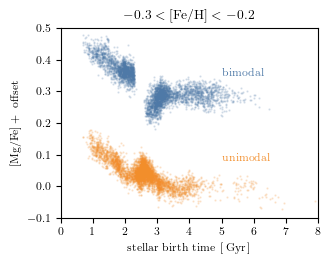

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))

logFeH0 = -0.25
dlogFeH = 0.05
s=0.4

data = simdata0
offset = 0
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH, data['logFeH'] < logFeH0 + dlogFeH)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[0], s=s, alpha=0.2, label='bimodal')

data = simdata1
offset = -0.3
key = np.logical_and(data['logFeH'] > logFeH0 - dlogFeH, data['logFeH'] < logFeH0 + dlogFeH)
ax.scatter(data['tform'][key], data['logMgFe'][key]+offset, c=tb_c[1], s=s, alpha=0.2, label='unimodal')

ax.set(xlim=(0, 8), ylim=(-0.1, 0.5), title=r'$-0.3 < [\textrm{Fe}/\textrm{H}] < -0.2$')
ax.set(xlabel=r'$\textrm{stellar birth time }\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
ax.text(5, 0.35, r'$\textrm{bimodal}$', c=tb_c[0])
ax.text(5, 0.08, r'$\textrm{unimodal}$', c=tb_c[1])
ax.set(xticks=np.arange(0, 8+1, 1))

# ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('alpha_vs_tform.pdf')